# 성인 인구조사 소득 예측 대회

한국과 마찬가지로 미국도 주기적으로 성인을 대상으로 한 여러 인구조사를 시행합니다.
이 대회는 1994년 미국 성인을 대상으로 조사한 데이터를 바탕으로 진행됩니다.

여러분은 이 데이터에서 각 사람의 소득을 예측하면 됩니다.

나이, 결혼 여부, 직종 등 총 14개의 feature를 통해 예측을 하면 됩니다.
예측해야 하는 값은 간단합니다.

연소득이 $50,000 이 넘는다면 1
연소득이 $50,000 이 넘지 않는다면 0

## 데이터 설명

* 데이터 세부 설명
* train/test는 14개의 columns으로 구성되어 있고, train은 예측해야 하는 target 값 feature까지 1개가 추가로 있습니다. 각 데이터는 다음을 의미합니다.

* id
* age : 나이
* workclass : 고용 형태
* fnlwgt : 사람 대표성을 나타내는 가중치 (final weight의 약자)
* education : 교육 수준
* education_num : 교육 수준 수치
* marital_status: 결혼 상태
* occupation : 업종
* relationship : 가족 관계
* race : 인종
* sex : 성별
* capital_gain : 양도 소득
* capital_loss : 양도 손실
* hours_per_week : 주당 근무 시간
* native_country : 국적
* income : 수익 (예측해야 하는 값)
* >50K : 1
* <=50K : 0

## <center style="background-color:black; width:40%;">Contents</center>
* [데이터 읽어오기.](#데이터_읽어오기)
* [목표변수 0, 1 변환](#목표변수)
* [연령 카테고리화 및 연령대 별 50K이상 비율](#연령대)
* [소득 별 final weight 히스토그램 및 2 sample test](#FINAL_WEIGHT)
* [소득 별 교육 수준](#교육수준)
* [소득 별 결혼 여부](#결혼)
* [소득 별 업종](#업종)
* [소득 별 가족 관계](#가족)
* [소득 별 인종](#인종)
* [소득 별 성별](#성별)
* [소득 별 양도 소득](#양도소득)
* [소득 별 양도 손실](#양도손실)
* [소득 별 주당 근무 시간](#주당근무시간)
* [소득 별 국적](#국적)
* [인종 & 성별 별 소득이 50K가 넘는 비율](#파생1)
* [결측치 및 이상치 도출](#결측치_이상치)
* [데이터 범주형 데이터 인코딩 및 목표변수 검증데이터셋 분류](#데이터_분류)
* [로지스틱 회귀분석](#로지스틱)
* [의사결정나무](#의사결정나무)
* [앙상블_랜덤포레스트](#랜덤포레스트)
* [앙상블_그래디언트 부스팅](#그래디언트부스팅)
* [SVM](#SVM)
* [인공신경망](#인공신경망)
* [KNN](#KNN)
* [XGBOOST](#XGBOOST)
* [Light GBM](#Light_GBM)
* [모델 평가](#평가)

<a class="anchor" id="데이터_읽어오기"></a>
## <center style="background-color:black; width:40%;">데이터 읽어오기.</center>

In [2]:
import numpy as np 
import pandas as pd 
import os
#데이터 구성 패키지
import pandas as pd
#행렬 연산 패키지
import numpy as np
#데이터 시각화 패키지
import matplotlib
#한글 폰트 적용
matplotlib.rc('font', family='Malgun Gothic')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import omni_normtest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/kakr-4th-competition/sample_submission.csv
/kaggle/input/kakr-4th-competition/train.csv
/kaggle/input/kakr-4th-competition/test.csv


In [3]:
origin_data = pd.read_csv('/kaggle/input/kakr-4th-competition/train.csv')
data = origin_data.copy()

In [4]:
data.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


In [5]:
data.isnull().sum()

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

<a class="anchor" id="목표변수"></a>
## <center style="background-color:black; width:40%;">목표변수 0,1 변환.</center>

In [8]:
data['income'].describe()

count     26049
unique        2
top       <=50K
freq      19744
Name: income, dtype: object

In [11]:
data['income'].head()

0     >50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

In [12]:
data['income'][data['income']=='>50K'] = 1
data['income'][data['income']=='<=50K'] = 0

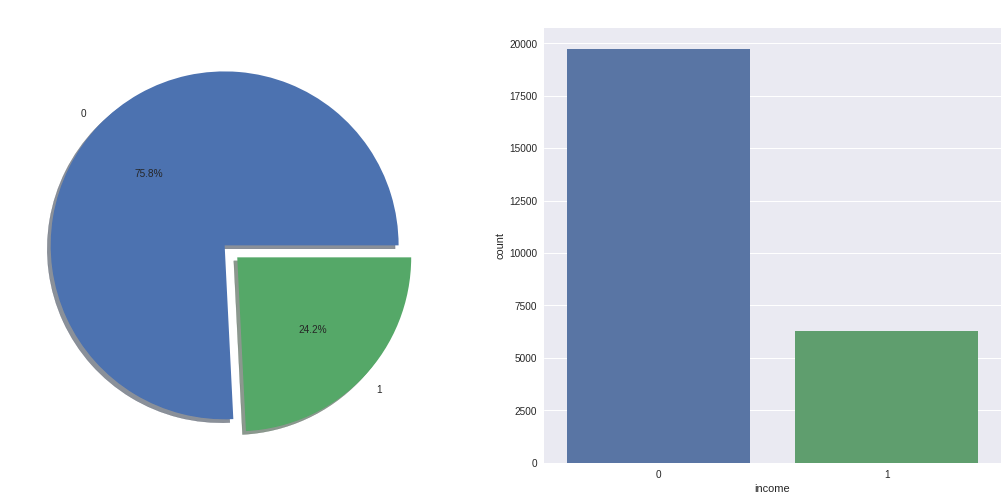

In [20]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
data['income'].value_counts().plot.pie(explode=[0, 0.1], autopct = '%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('INCOME', size = 20, color = 'white')
ax[0].set_ylabel('')
sns.countplot('income', data=data, ax=ax[1])
ax[1].set_title('INCOME',size = 20, color = 'white')
plt.show()

## 목표데이터는 Unbalanced 하다.

<a class="anchor" id="연령대"></a>
## <center style="background-color:black; width:80%;">연령 카테고리화 및 연령대 별 50K이상 비율.</center>

In [23]:
print(data['age'].describe())
data['age'][data['age']==90].count()

36

In [ ]:
data['age'][(data['age'] >= 10) & (data['age'] < 20)] = 10
data['age'][(data['age'] >= 20) & (data['age'] < 30)] = 20
data['age'][(data['age'] >= 30) & (data['age'] < 40)] = 30
data['age'][(data['age'] >= 40) & (data['age'] < 50)] = 40
data['age'][(data['age'] >= 50) & (data['age'] < 60)] = 50
data['age'][(data['age'] >= 60) & (data['age'] < 70)] = 60
data['age'][(data['age'] >= 70) & (data['age'] < 80)] = 70
data['age'][(data['age'] >= 80) & (data['age'] < 90)] = 80
data['age'][(data['age'] >= 90) & (data['age'] < 100)] = 90
